<a href="https://colab.research.google.com/github/tarumi283/tarumi/blob/main/RNAseq%E8%A7%A3%E6%9E%90%E7%94%A8GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip -q install scanpy anndata pandas numpy scipy matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 78.0 MB/s eta 0:00:00


In [3]:
import subprocess, tarfile, re
from pathlib import Path

GSE = "GSE162931"
BASE = Path("data")/GSE
BASE.mkdir(parents=True, exist_ok=True)

def geo_suppl_url(gse: str) -> str:
    n = int(gse.replace("GSE",""))
    prefix = f"GSE{n//1000}"  # 例: 162931 -> GSE162
    return f"https://ftp.ncbi.nlm.nih.gov/geo/series/{prefix}nnn/{gse}/suppl"

suppl = geo_suppl_url(GSE)
raw_tar = BASE/f"{GSE}_RAW.tar"

# download
if not raw_tar.exists():
    subprocess.run(["wget","-nc","-P",str(BASE), f"{suppl}/{GSE}_RAW.tar"], check=True)

# outer tar -> inner tar.gz files
inner_dir = BASE/"inner_tarballs"
inner_dir.mkdir(exist_ok=True)

with tarfile.open(raw_tar, "r") as t:
    t.extractall(inner_dir)

inner_tars = sorted(inner_dir.glob("GSM*_filtered_feature_bc_matrix.tar.gz"))
print("Inner tar.gz files:", len(inner_tars))
print([p.name for p in inner_tars])


/tmp/ipython-input-1209259126.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(inner_dir)


Inner tar.gz files: 8
['GSM4967236_Lee1_filtered_feature_bc_matrix.tar.gz', 'GSM4967237_Lee2_filtered_feature_bc_matrix.tar.gz', 'GSM4967239_Lee3_filtered_feature_bc_matrix.tar.gz', 'GSM4967241_Lee4_filtered_feature_bc_matrix.tar.gz', 'GSM4967242_Lee5_filtered_feature_bc_matrix.tar.gz', 'GSM4967244_Lee6_filtered_feature_bc_matrix.tar.gz', 'GSM4967246_Lee7_filtered_feature_bc_matrix.tar.gz', 'GSM4967248_Lee8_filtered_feature_bc_matrix.tar.gz']


In [4]:
import tarfile, re
from pathlib import Path
import scanpy as sc

GSE = "GSE162931"
BASE = Path("data")/GSE
inner_dir = BASE/"inner_tarballs"
extract_root = BASE/"samples_extracted"
extract_root.mkdir(exist_ok=True)

inner_tars = sorted(inner_dir.glob("GSM*_filtered_feature_bc_matrix.tar.gz"))
assert len(inner_tars) > 0, "inner tar.gz が見つかりません。セル1を先に実行して下さい。"

adatas = []
for tgz in inner_tars:
    m = re.match(r"(GSM\d+)_([^_]+)_filtered_feature_bc_matrix\.tar\.gz", tgz.name)
    gsm = m.group(1); tag = m.group(2)

    out = extract_root/f"{gsm}_{tag}"
    out.mkdir(exist_ok=True)

    # extract only once
    if not any(out.iterdir()):
        with tarfile.open(tgz, "r:gz") as t:
            t.extractall(out)

    print("Reading:", gsm, tag)
    ad = sc.read_10x_mtx(str(out), var_names="gene_symbols", cache=False)
    ad.var_names_make_unique()
    ad.obs["GSM"] = gsm
    ad.obs["sample_tag"] = tag
    adatas.append(ad)

adata = sc.concat(adatas, join="outer")
print("Merged:", adata)

out_h5ad = BASE/f"{GSE}_merged.h5ad"
adata.write(out_h5ad)
print("Saved:", out_h5ad)


/tmp/ipython-input-1394850689.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(out)


Reading: GSM4967236 Lee1


/tmp/ipython-input-1394850689.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(out)


Reading: GSM4967237 Lee2


/tmp/ipython-input-1394850689.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(out)


Reading: GSM4967239 Lee3


/tmp/ipython-input-1394850689.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(out)


Reading: GSM4967241 Lee4


/tmp/ipython-input-1394850689.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(out)


Reading: GSM4967242 Lee5


/tmp/ipython-input-1394850689.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(out)


Reading: GSM4967244 Lee6


/tmp/ipython-input-1394850689.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(out)


Reading: GSM4967246 Lee7


/tmp/ipython-input-1394850689.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall(out)


Reading: GSM4967248 Lee8


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Merged: AnnData object with n_obs × n_vars = 90822 × 33694
    obs: 'GSM', 'sample_tag'
Saved: data/GSE162931/GSE162931_merged.h5ad


In [5]:
# OCT4 = POU5F1, CD144 = CDH5, BMAL1 = ARNTL
STEMNESS = ["SOX2","POU5F1","CDH5","KLF4"]

CIRCADIAN = ["ARNTL","CLOCK","PER1","PER2","CRY1","CRY2"]

# NAD+ 代謝 + 解糖（最小・助成金用に説明しやすいセット）
METABOLIC_SIMPLE = [
    "NAMPT","NMNAT1","NMNAT2","NMNAT3","NADSYN1","NAPRT",
    "SIRT1","SIRT2","SIRT6","PARP1","CD38",
    "SLC2A1","HK2","PFKM","PKM","LDHA"
]

# 老化コア（p16/p21中心）
SENESCENCE_CORE = ["CDKN2A","CDKN1A","TP53","GLB1","SERPINE1"]

# SASP（最小）
SASP = ["IL6","IL8","CXCL1","CCL2","MMP3","MMP9","ICAM1","PTGS2","TGFB1"]

# 増殖（対照）
PROLIFERATION = ["MKI67","TOP2A","PCNA","MCM2","CCNB1","CDK1"]

print("Gene sets loaded.")


Gene sets loaded.


In [6]:
import scanpy as sc
import numpy as np
from pathlib import Path
from sklearn.cluster import KMeans

GSE = "GSE162931"
BASE = Path("data")/GSE
adata = sc.read_h5ad(BASE/f"{GSE}_merged.h5ad")

# ===== メタデータ（RT time-course）=====
meta = {
    "GSM4967236": dict(line="GBM131", condition="naive", timepoint="0d"),
    "GSM4967237": dict(line="GBM131", condition="RT",    timepoint="2d"),
    "GSM4967239": dict(line="GBM131", condition="RT",    timepoint="5d"),
    "GSM4967241": dict(line="GBM131", condition="RT",    timepoint="3w"),
    "GSM4967242": dict(line="GBM022", condition="naive", timepoint="0d"),
    "GSM4967244": dict(line="GBM022", condition="RT",    timepoint="2d"),
    "GSM4967246": dict(line="GBM827", condition="naive", timepoint="0d"),
    "GSM4967248": dict(line="GBM827", condition="RT",    timepoint="2d"),
}
adata.obs["line"] = adata.obs["GSM"].map(lambda x: meta[str(x)]["line"])
adata.obs["condition"] = adata.obs["GSM"].map(lambda x: meta[str(x)]["condition"])
adata.obs["timepoint"] = adata.obs["GSM"].map(lambda x: meta[str(x)]["timepoint"])

# ===== 出力先 =====
OUTDIR = Path("out_GSE162931")
OUTDIR.mkdir(exist_ok=True)
sc.settings.figdir = str(OUTDIR)
sc.settings.set_figure_params(dpi=220, fontsize=10)

# ===== 前処理 =====
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata = adata[adata.obs.pct_counts_mt < 20].copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata)

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

# ===== KMeansクラスタ（igraph不要）=====
k = 10
km = KMeans(n_clusters=k, random_state=0, n_init="auto")
adata.obs["kmeans"] = km.fit_predict(adata.obsm["X_pca"][:, :30]).astype(str)

# ===== スコア =====
def score(genes, name):
    g = [x for x in genes if x in adata.var_names]
    if len(g) < 2:
        adata.obs[name] = np.nan
        print(f"[WARN] {name}: too few genes ({len(g)})")
        return
    sc.tl.score_genes(adata, g, score_name=name)

score(STEMNESS, "StemnessScore")
score(CIRCADIAN, "CircadianScore")
score(METABOLIC_SIMPLE, "MetabolicScore")
score(SENESCENCE_CORE, "SenescenceCoreScore")
score(SASP, "SASPScore")
score(PROLIFERATION, "ProliferationScore")

# ===== 図（助成金用セット）=====
sc.pl.umap(adata, color=["line","condition","timepoint","kmeans"], wspace=0.4,
           show=False, save="_meta.png")

sc.pl.umap(adata, color=["StemnessScore","MetabolicScore","CircadianScore","SenescenceCoreScore","SASPScore","ProliferationScore"],
           wspace=0.4, show=False, save="_scores.png")

sc.pl.violin(adata,
             keys=["StemnessScore","MetabolicScore","CircadianScore","SenescenceCoreScore","SASPScore","ProliferationScore"],
             groupby="condition", rotation=45, show=False, save="_scores_by_condition.png")

sc.pl.violin(adata,
             keys=["StemnessScore","MetabolicScore","CircadianScore","SenescenceCoreScore","SASPScore","ProliferationScore"],
             groupby="timepoint", rotation=45, show=False, save="_scores_by_timepoint.png")

# 保存
adata.write(OUTDIR/"GSE162931_processed_scores_noigraph.h5ad")
print("DONE. Figures in:", OUTDIR)
print("Saved processed h5ad:", OUTDIR/"GSE162931_processed_scores_noigraph.h5ad")


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  

[WARN] CircadianScore: too few genes (0)
DONE. Figures in: out_GSE162931
Saved processed h5ad: out_GSE162931/GSE162931_processed_scores_noigraph.h5ad


In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

OUTDIR = Path("out_GSE162931")
adata = sc.read_h5ad(OUTDIR/"GSE162931_processed_scores_noigraph.h5ad")

plt.figure(figsize=(6,5))
for cond, m in [("naive","o"), ("RT","^")]:
    idx = adata.obs["condition"] == cond
    plt.scatter(
        adata.obs.loc[idx, "SenescenceCoreScore"],
        adata.obs.loc[idx, "StemnessScore"],
        s=8, alpha=0.5, marker=m, label=cond
    )

plt.xlabel("Senescence core score (p16/p21 axis)")
plt.ylabel("Stemness score (SOX2/OCT4/KLF4/CD144)")
plt.title("Senescence–stemness duality after radiation")
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig(OUTDIR/"scatter_Senescence_vs_Stemness.png", dpi=300)
plt.show()

print("Saved:", OUTDIR/"scatter_Senescence_vs_Stemness.png")


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


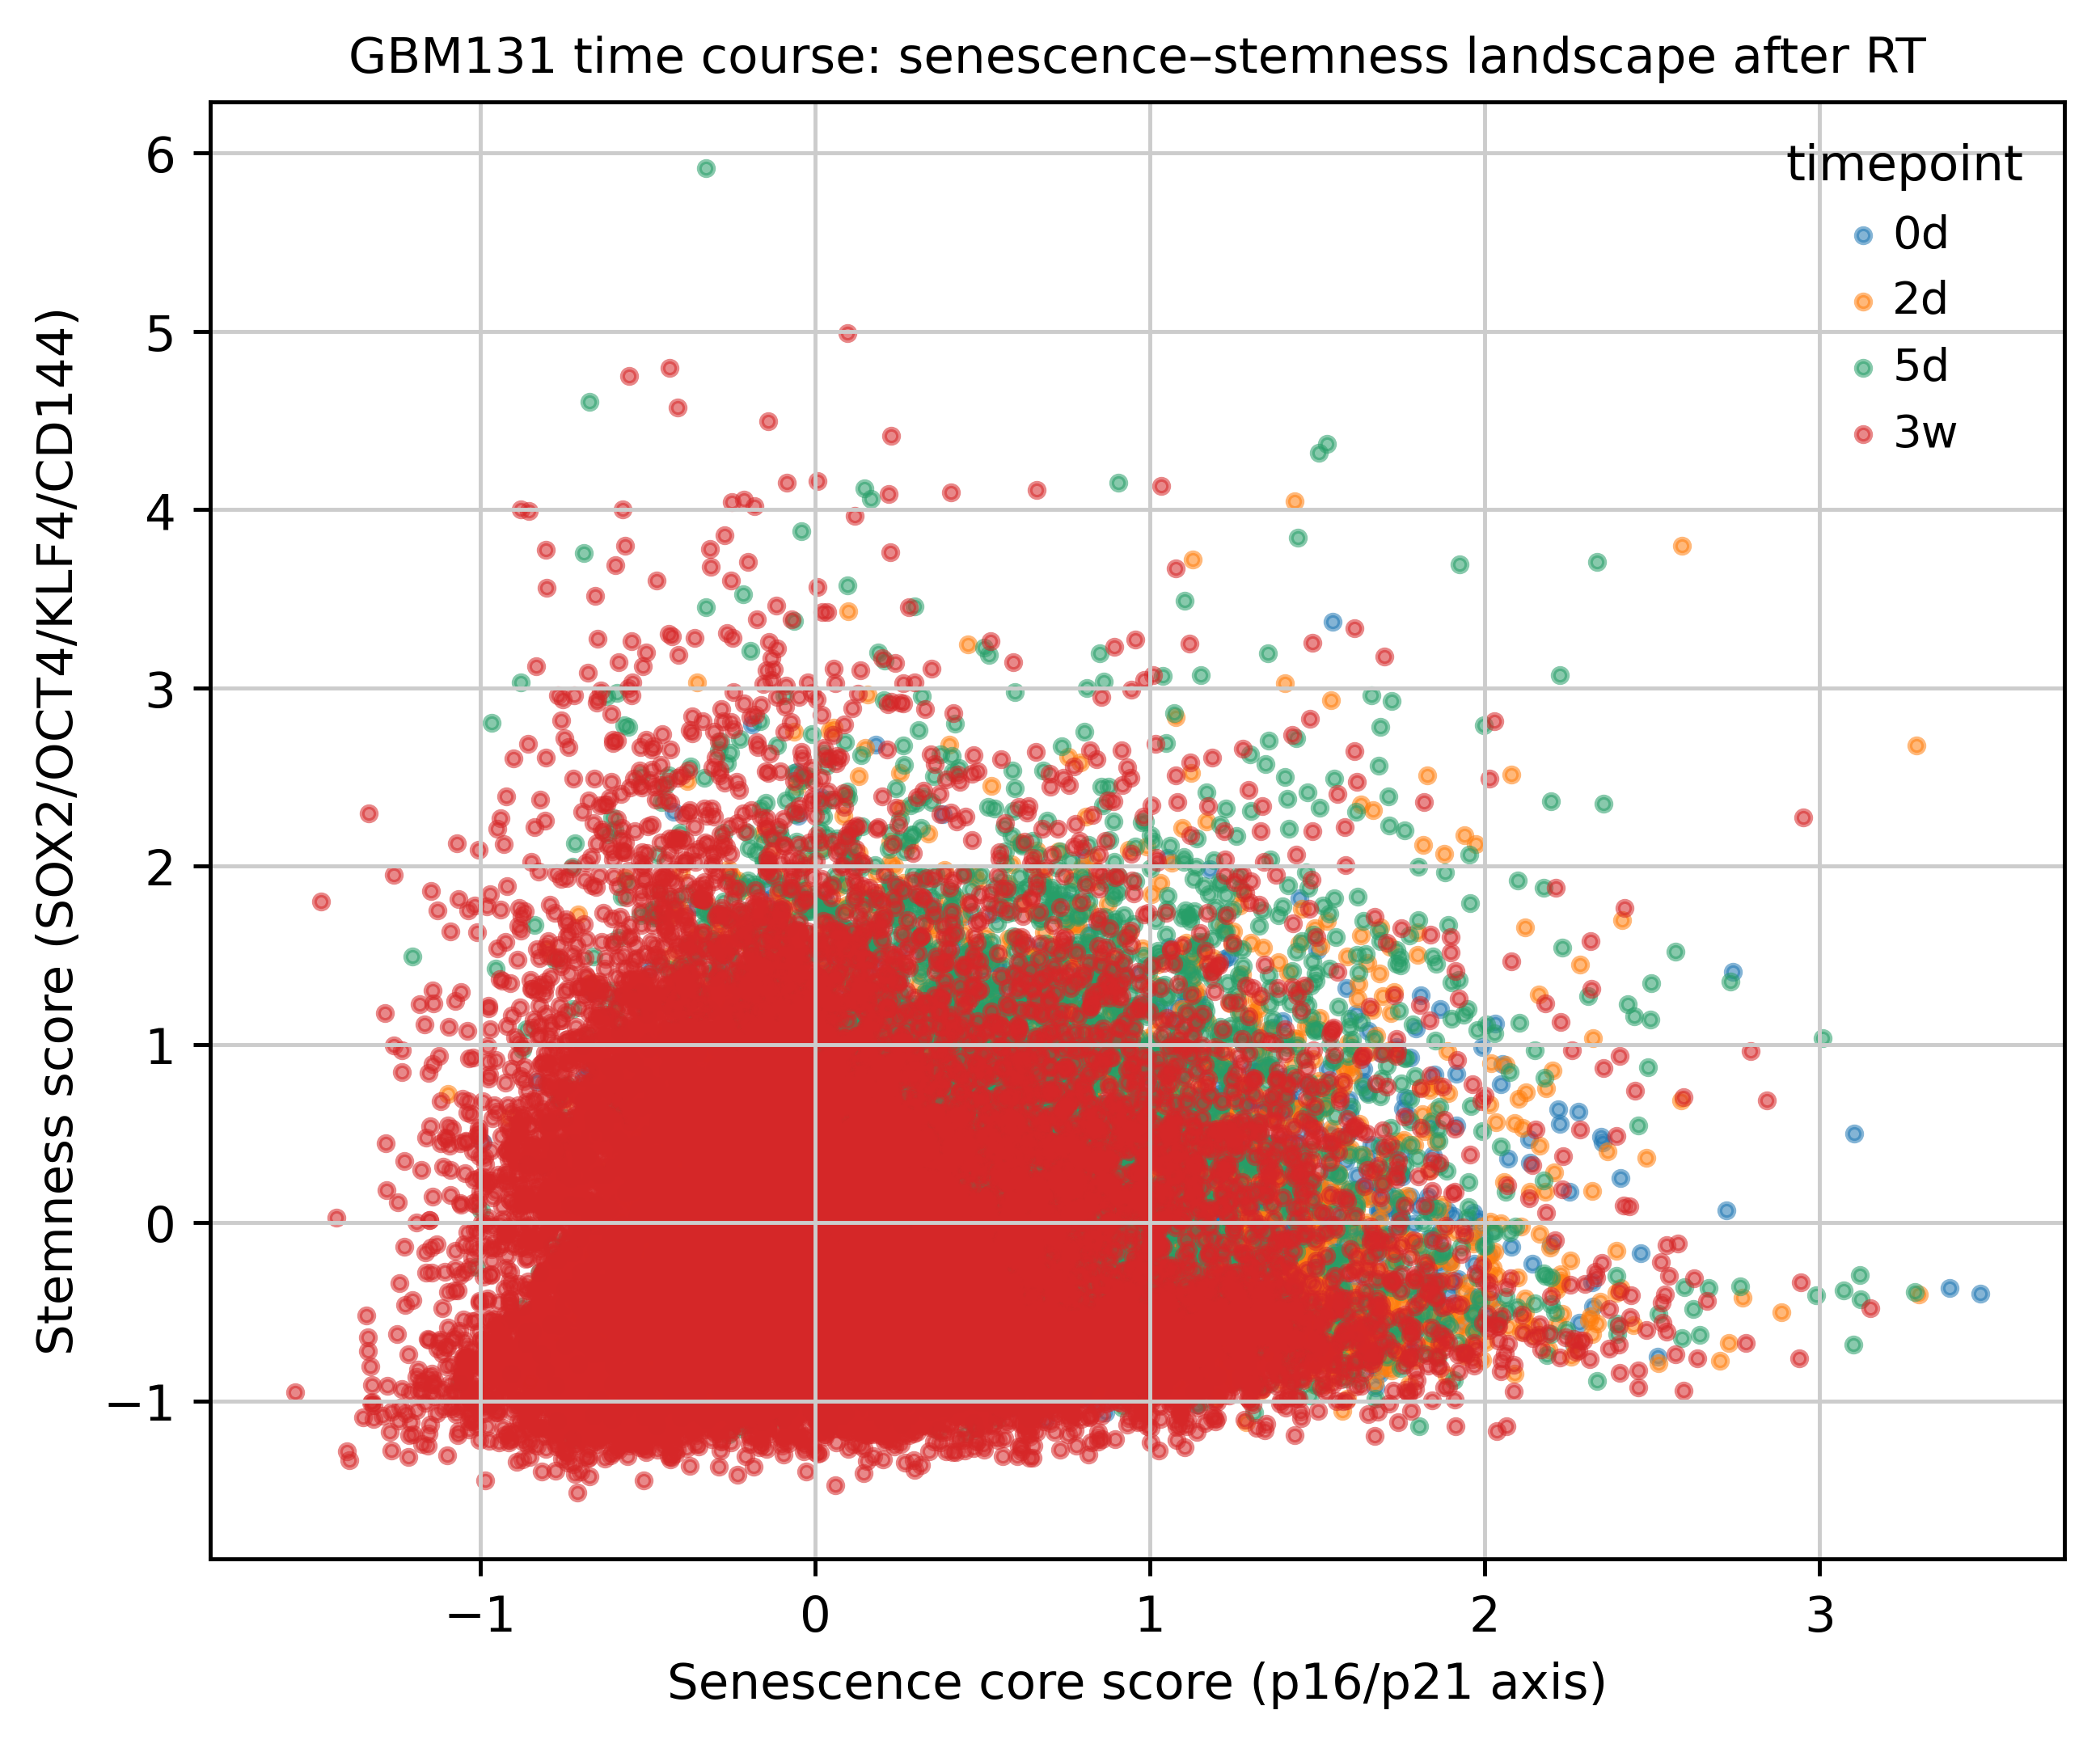

Saved: out_GSE162931/scatter_GBM131_timecourse.png
Thresholds (median of naive):
  SenescenceCoreScore thr = -0.32644559720752175
  StemnessScore thr       = -0.0902947818340565


/tmp/ipython-input-566342975.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(group_cols, dropna=False)


Saved: out_GSE162931/quadrant_UR_fraction_by_group.csv


,line,condition,timepoint,n_cells,ur_cells,ur_frac,sen_mean,stem_mean
0,GBM022,RT,0d,0,0,NaN,NaN,NaN
1,GBM022,RT,2d,11018,897,0.081412,-0.333018,-0.188540
3,GBM022,RT,5d,0,0,NaN,NaN,NaN
2,GBM022,RT,3w,0,0,NaN,NaN,NaN
4,GBM022,naive,0d,8829,274,0.031034,-0.394881,-0.164619
5,GBM022,naive,2d,0,0,NaN,NaN,NaN
7,GBM022,naive,5d,0,0,NaN,NaN,NaN
6,GBM022,naive,3w,0,0,NaN,NaN,NaN
8,GBM131,RT,0d,0,0,NaN,NaN,NaN
9,GBM131,RT,2d,7336,2353,0.320747,0.416215,-0.161298


Saved: out_GSE162931/quadrant_UR_fraction_pivot.csv


/tmp/ipython-input-566342975.py:84: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = tab.pivot_table(index=["line","timepoint"], columns="condition", values="ur_frac")


condition               RT     naive
line   timepoint                    
GBM022 0d              NaN  0.031034
       2d         0.081412       NaN
GBM131 0d              NaN  0.449222
       2d         0.320747       NaN
       5d         0.482986       NaN
       3w         0.250325       NaN
GBM827 0d              NaN  0.238227
       2d         0.801834       NaN

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc

OUTDIR = Path("out_GSE162931")
adata = sc.read_h5ad(OUTDIR/"GSE162931_processed_scores_noigraph.h5ad")

# -----------------------------
# ① GBM131のみ：timepoint色分け散布
# -----------------------------
gbm131 = adata[adata.obs["line"]=="GBM131"].copy()

order = ["0d","2d","5d","3w"]
for tp in order:
    if tp not in set(gbm131.obs["timepoint"]):
        print("[WARN] missing timepoint in GBM131:", tp)

plt.figure(figsize=(6,5))
for tp in order:
    idx = gbm131.obs["timepoint"] == tp
    if idx.sum() == 0:
        continue
    plt.scatter(
        gbm131.obs.loc[idx, "SenescenceCoreScore"],
        gbm131.obs.loc[idx, "StemnessScore"],
        s=8, alpha=0.55, label=tp
    )

plt.xlabel("Senescence core score (p16/p21 axis)")
plt.ylabel("Stemness score (SOX2/OCT4/KLF4/CD144)")
plt.title("GBM131 time course: senescence–stemness landscape after RT")
plt.legend(frameon=False, title="timepoint")
plt.tight_layout()
plt.savefig(OUTDIR/"scatter_GBM131_timecourse.png", dpi=300)
plt.show()
print("Saved:", OUTDIR/"scatter_GBM131_timecourse.png")


# -----------------------------
# ② Quadrant解析：右上割合（Sen↑ & Stem↑）
#   しきい値 = naive(全line)の中央値（頑健・助成金向け）
# -----------------------------
naive = adata[adata.obs["condition"]=="naive"]
sen_thr = float(np.nanmedian(naive.obs["SenescenceCoreScore"]))
stem_thr = float(np.nanmedian(naive.obs["StemnessScore"]))

print("Thresholds (median of naive):")
print("  SenescenceCoreScore thr =", sen_thr)
print("  StemnessScore thr       =", stem_thr)

adata.obs["Q_SenHigh"]  = adata.obs["SenescenceCoreScore"] >= sen_thr
adata.obs["Q_StemHigh"] = adata.obs["StemnessScore"] >= stem_thr
adata.obs["Q_UR"] = (adata.obs["Q_SenHigh"] & adata.obs["Q_StemHigh"])  # upper-right

group_cols = ["line","condition","timepoint"]
tab = (
    adata.obs
    .groupby(group_cols, dropna=False)
    .agg(
        n_cells=("Q_UR","size"),
        ur_cells=("Q_UR","sum"),
        ur_frac=("Q_UR","mean"),
        sen_mean=("SenescenceCoreScore","mean"),
        stem_mean=("StemnessScore","mean"),
    )
    .reset_index()
)

# 見やすい並び
tp_cat = pd.Categorical(tab["timepoint"], categories=["0d","2d","5d","3w"], ordered=True)
tab["timepoint"] = tp_cat
tab = tab.sort_values(["line","condition","timepoint"])

# 保存
tab.to_csv(OUTDIR/"quadrant_UR_fraction_by_group.csv", index=False)
print("Saved:", OUTDIR/"quadrant_UR_fraction_by_group.csv")

# 画面表示（上位だけ）
display(tab)

# 右上割合だけのピボット（助成金で貼りやすい）
pivot = tab.pivot_table(index=["line","timepoint"], columns="condition", values="ur_frac")
pivot.to_csv(OUTDIR/"quadrant_UR_fraction_pivot.csv")
print("Saved:", OUTDIR/"quadrant_UR_fraction_pivot.csv")
display(pivot)
